In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from pandas.plotting import autocorrelation_plot
from scipy.optimize import curve_fit

path = 'results'


Lo scopo di questa esercitazione è quello di implementare un codice di dinamica molecolare che simula il comportamento delle molecole di un fluido di Lennard-Jones in equilibrio termico con l'ambiente circostante. Nello specifico l'algoritmo fornito simula la posizione delle particelle le quali vengono campionate mediante l'utlizzo dell'algoritmo di metropolis. In base alle posizioni, viene calcolata istante per istante (ad ogni passo montacarlo) il valore di pressione ed energia potenziale del fluido. Sottolineamo il fatto che il sistema che stiamo studiando è considerato infinito (in modo da non avere effetti dovuti alla interazione delle particelle con i bordi) quindi le posizioni sono simulate in periodic boundary condition.
Sono state fatte in tutto tre simulazioni per indagare il comportameto del sistema in tre diversi stati: solido, liquido, gas. Riportiamo fin da subito i parametri delle tre simulazioni (tutte le grandezze sono in unità ridotte)

- fase solida: $\rho^\star = 1.1$, $T^\star = 0.8$ (raggio di cut-off : $r_c = 2.2$)
- fase liquida: $\rho^\star = 0.8$, $T^\star = 1.1$ (raggio di cut-off : $r_c = 2.5$)
- fase gassosa: $\rho^\star = 0.05$, $T^\star = 1.2$ (raggio di cut-off : $r_c = 5.0$)

### Esercizio 07.1.1 
Il primo obbiettivo di questa esercitazione è stato quello di calcolare il tempo (in passi montecarlo) di correlazione delle quantità simulate. Ricordiamo infatti che i punti campinati mediante il metodo metropolis non sono scorrelati, il nostro scopo è quindi calcolare dopo quanti passi montecarlo le misure tornano ad essere scorrelate.

Per fare questo abbiamo simulato $10^4$ passi montecarlo e abbiamo calcolato i valori istantanei di pressione ed enegia potenziale (che riportiamo di seguito). Con questi dati abbiamo calcolato il valore di autocorrelazione al variare del valore del lag e ne  abbiamo fatto il grafico. Aspettandoci un decadimento esponenziale, abbiamo quindi fatto il fit con la funzione 
$f(t)=Ne^{\frac{-t}{\tau}}$

Mostriamo quindi i risultati ottenuti

In [2]:
db_u_g = pd.read_csv(path + '/U_optimization_gas', header = None)
db_p_g = pd.read_csv(path + '/P_otimization_gas', header = None)
db_gas = pd.DataFrame(columns = ['P', 'U'])
db_gas['P'] = list(db_p_g.iloc[:,0])
db_gas['U'] = list(db_u_g.iloc[:,0])

In [3]:
db_u_s = pd.read_csv(path + '/U_optimization_solid', header = None)
db_p_s = pd.read_csv(path + '/P_otimization_solid', header = None)
db_solid = pd.DataFrame(columns = ['P', 'U'])
db_solid['P'] = list(db_p_s.iloc[:,0])
db_solid['U'] = list(db_u_s.iloc[:,0])

In [4]:
db_u_l = pd.read_csv(path + '/U_optimization_liquid', header = None)
db_p_l = pd.read_csv(path + '/P_otimization_liquid', header = None)
db_liquid = pd.DataFrame(columns = ['P', 'U'])
db_liquid['P'] = list(db_p_l.iloc[:,0])
db_liquid['U'] = list(db_u_l.iloc[:,0])

In [5]:
def decay(t, tau, N):
    return N*np.exp(-t/tau) #modello esponenziale con cui fittare i dati

In [6]:
ac_u_gas = []
ac_p_gas = []
ac_u_solid = []
ac_p_solid = []
ac_u_liquid = []
ac_p_liquid = []
n=[]

for i in range(0, 10000):
    ac_u_gas.append(db_gas['U'].autocorr(lag = i))  #gas
    ac_p_gas.append(db_gas['P'].autocorr(lag = i))
    
    ac_u_solid.append(db_solid['U'].autocorr(lag = i))  #solid
    ac_p_solid.append(db_solid['P'].autocorr(lag = i))
    
    ac_u_liquid.append(db_liquid['U'].autocorr(lag = i)) #liquid
    ac_p_liquid.append(db_liquid['P'].autocorr(lag = i))
    
    n.append(i)
    
ac_gas = pd.DataFrame(columns = ['n', 'ac_u', 'ac_p']) #dataframe autocorrelazione gas
ac_gas['n'] = n
ac_gas['ac_u'] = ac_u_gas
ac_gas['ac_p'] = ac_p_gas

ac_solid = pd.DataFrame(columns = ['n', 'ac_u', 'ac_p'])
ac_solid['n'] = n
ac_solid['ac_u'] = ac_u_solid
ac_solid['ac_p'] = ac_p_solid

ac_liquid = pd.DataFrame(columns = ['n', 'ac_u', 'ac_p'])
ac_liquid['n'] = n
ac_liquid['ac_u'] = ac_u_liquid
ac_liquid['ac_p'] = ac_p_liquid

pu_gas, covu_gas = curve_fit(decay, ac_gas['n'] , ac_gas['ac_u'])
yu_gas = decay(ac_gas['n'],pu_gas[0],pu_gas[1])

pp_gas, covp_gas = curve_fit(decay, ac_gas['n'] , ac_gas['ac_p'])
yp_gas = decay(ac_gas['n'],pp_gas[0],pp_gas[1])


pu_solid, covu_solid = curve_fit(decay, ac_solid['n'] , ac_solid['ac_u'])
yu_solid = decay(ac_solid['n'],pu_solid[0],pu_solid[1])
pp_solid, covp_solid = curve_fit(decay, ac_solid['n'] , ac_solid['ac_p'])
yp_solid = decay(ac_solid['n'],pp_solid[0],pp_solid[1])

pu_liquid, covu_liquid = curve_fit(decay, ac_liquid['n'] , ac_liquid['ac_u'])
yu_liquid = decay(ac_liquid['n'],pu_liquid[0],pu_liquid[1])
pp_liquid, covp_liquid = curve_fit(decay, ac_liquid['n'] , ac_liquid['ac_p'])
yp_liquid = decay(ac_liquid['n'],pp_liquid[0],pp_liquid[1])

In [7]:
print("parametri del fit dell'autocorrelazione dell'energia potenziale nello stato liquido: ")
print(pu_liquid)

print("parametri del fit dell'autocorrelazione dell'energia potenziale nello stato solido: ")
print(pu_solid)

print("parametri del fit dell'autocorrelazione dell'energia potenziale nello stato gassoso: ")
print(pu_gas)

print("parametri del fit dell'autocorrelazione della pressione nello stato liquido: ")
print(pp_liquid)

print("parametri del fit dell'autocorrelazione della pressione nello stato solido: ")
print(pp_solid)

print("parametri del fit dell'autocorrelazione della pressione nello stato gassoso: ")
print(pp_gas)

parametri del fit dell'autocorrelazione dell'energia potenziale nello stato liquido: 
[20.37264237  0.63884345]
parametri del fit dell'autocorrelazione dell'energia potenziale nello stato solido: 
[9.03870462 0.90494881]
parametri del fit dell'autocorrelazione dell'energia potenziale nello stato gassoso: 
[2.81216826e+03 5.43189382e-01]
parametri del fit dell'autocorrelazione della pressione nello stato liquido: 
[26.40606012  0.63848453]
parametri del fit dell'autocorrelazione della pressione nello stato solido: 
[8.83644891 0.90850919]
parametri del fit dell'autocorrelazione della pressione nello stato gassoso: 
[11.33243715  0.83136757]


(-100, 1000)

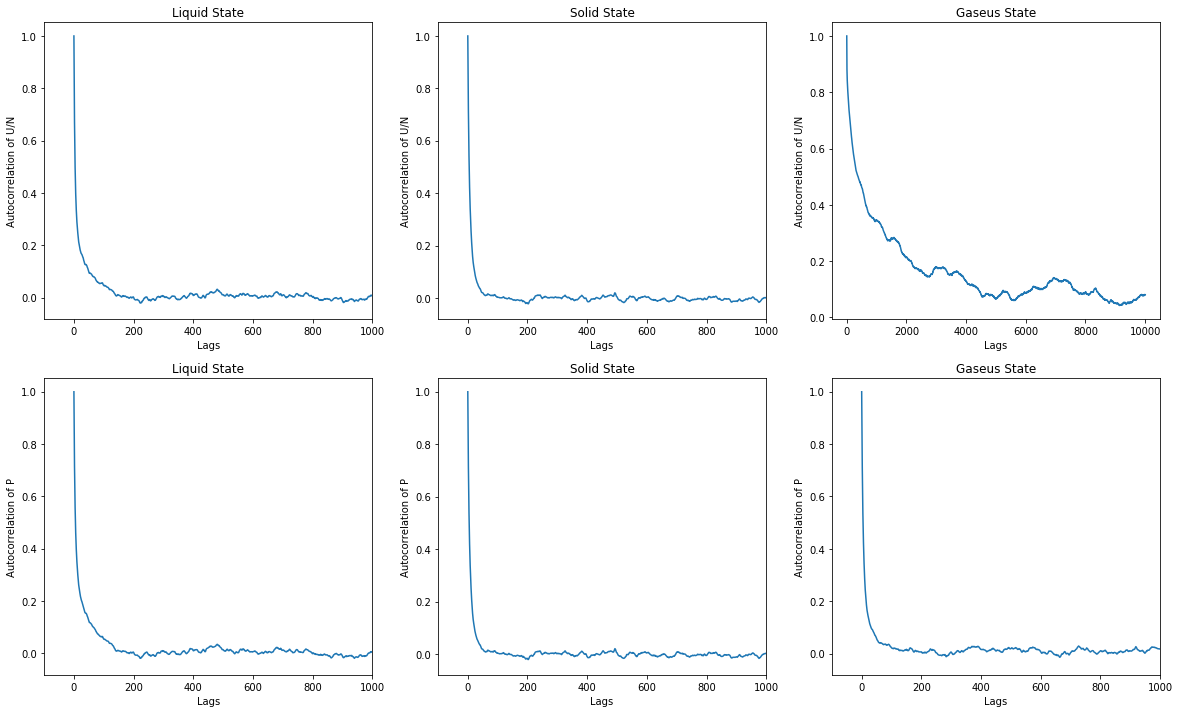

In [8]:
fig, axs = plt.subplots(2, 3, figsize = (20, 12))

axs[0, 0].plot(n, ac_liquid['ac_u'])    #gas 
axs[0, 0].set_title('Liquid State')
axs[0, 0].set(xlabel='Lags', ylabel='Autocorrelation of U/N')
axs[0, 0].set_xlim((-100, 1000))

axs[0, 1].plot(n, ac_solid['ac_u'])    #solid
axs[0, 1].set_title('Solid State')
axs[0, 1].set(xlabel='Lags', ylabel='Autocorrelation of U/N')
axs[0, 1].set_xlim((-100, 1000))

axs[0, 2].plot(n, ac_gas['ac_u'])    #gas
axs[0, 2].set_title('Gaseus State')
axs[0, 2].set(xlabel='Lags', ylabel='Autocorrelation of U/N')

axs[1, 0].plot(n, ac_liquid['ac_p'])    #liquid
axs[1, 0].set_title('Liquid State')
axs[1, 0].set(xlabel='Lags', ylabel='Autocorrelation of P')
axs[1, 0].set_xlim((-100, 1000))

axs[1, 1].plot(n, ac_solid['ac_p'])    #solid
axs[1, 1].set_title('Solid State')
axs[1, 1].set(xlabel='Lags', ylabel='Autocorrelation of P')
axs[1, 1].set_xlim((-100, 1000))

axs[1, 2].plot(n, ac_gas['ac_p'])    #gas
axs[1, 2].set_title('Gaseus State')
axs[1, 2].set(xlabel='Lags', ylabel='Autocorrelation of P')
axs[1, 2].set_xlim((-100, 1000))

A partire dai valori ottenuti per i tempi di correlazione ($t_c$) è possibile stimare il numero di misure ($n$) statisticamente indipendenti dopo un numero $t_{max}$ di passi montecarlo, mediante la formula:

$n=t_{max}/2t_c$

o, viceversa, possiamo stimare il numero di passi montecarlo necessari per ottenere un campione di misure indipendenti di dimensione fissata. 

### Esercizio 7.1.2
Successivamente abbiamo usato gli stessi dati per stimare il valore di U/N e P con la relativa incertezza statistica utilizzando la tecnica di blocking.

In [34]:
def error(AV,AV2,n):  # Function for statistical uncertainty estimation
    if n==0:
        return 0
    else:
        return math.sqrt((AV2[n] - AV[n]**2)/n)

M=100000              # Total number of throws
L=[]
for i in range (10, 5000, 10):
    L.append(i)
number=np.array(L)
meanp_liquid=np.zeros(499)
sigmap_liquid=np.zeros(499)
meanu_liquid=np.zeros(499)
sigmau_liquid=np.zeros(499)

meanp_solid=np.zeros(499)
sigmap_solid=np.zeros(499)
meanu_solid=np.zeros(499)
sigmau_solid=np.zeros(499)

meanp_gas=np.zeros(499)
sigmap_gas=np.zeros(499)
meanu_gas=np.zeros(499)
sigmau_gas=np.zeros(499)


p_liquid=list(db_liquid.iloc[:,0])
u_liquid=list(db_liquid.iloc[:,1])

p_solid=list(db_solid.iloc[:,0])
u_solid=list(db_solid.iloc[:,1])

p_gas=list(db_gas.iloc[:,0])
u_gas=list(db_gas.iloc[:,1])

state=['liquid', 'solid', 'gas']
pressure=[]
energy=[]

In [38]:
for m in state:
    if m=='solid':
        pressure=p_solid
        energy=u_solid
    if m=='liquid':
        pressure=p_liquid
        energy=u_liquid
    if m=='gas':
        pressure=p_gas
        energy=u_gas
     
    for d in range(0,499):
        N=int(M/L[d])      #numero di blocchi
        l=L[d]             #numero di tiri in ogni blocco
        avep = np.zeros(N) #pressione media
        avp2 = np.zeros(N) #pressione quadrata media
        aveu = np.zeros(N) #energia interna media
        avu2 = np.zeros(N) #en
        sum_p = np.zeros(N)
        su2_p = np.zeros(N)
        err_p = np.zeros(N)  
        sum_u = np.zeros(N)
        su2_u = np.zeros(N)
        err_u = np.zeros(N)  
        for i in range(N):
            sump = 0
            sumu = 0
            for j in range(l):
                k = j+i*l
                sump += pressure[k]
                sumu += energy[k]
            avep[i] = sump/l        
            avp2[i] = (avep[i])**2  
            aveu[i] = sumu/l
            avu2[i] = (aveu[i])**2
        for s in range(N):
            for j in range(s+1):
                sum_p[s] += avep[j] 
                su2_p[s] += avp2[j] 
                sum_u[s] += aveu[j] 
                su2_u[s] += avu2[j] 
            sum_p[s]/=(s+1) # Cumulative average
            su2_p[s]/=(s+1) # Cumulative square average
            err_p[s] = error(sum_p,su2_p,s) # Statistical uncertainty
            sum_u[s]/=(s+1) # Cumulative average
            su2_u[s]/=(s+1) # Cumulative square average
            err_u[s] = error(sum_u,su2_u,s) # Statistical uncertainty    
           
        if m=='solid':
            meanp_solid[d]=sum_p[N-1]
            sigmap_solid[d]=err_p[N-1]
            meanu_solid[d]=sum_u[N-1]
            sigmau_solid[d]=err_u[N-1]
        if m=='liquid':
            meanp_liquid[d]=sum_p[N-1]
            sigmap_liquid[d]=err_p[N-1]
            meanu_liquid[d]=sum_u[N-1]
            sigmau_liquid[d]=err_u[N-1]
        if m=='gas':
            meanp_gas[d]=sum_p[N-1]
            sigmap_gas[d]=err_p[N-1]
            meanu_gas[d]=sum_u[N-1]
            sigmau_gas[d]=err_u[N-1]
        del avep, aveu, avp2, avu2, sum_p, sum_u, su2_p, su2_u, err_p, err_u 

[Text(0, 0.5, 'Sigma_u'), Text(0.5, 0, 'Number')]

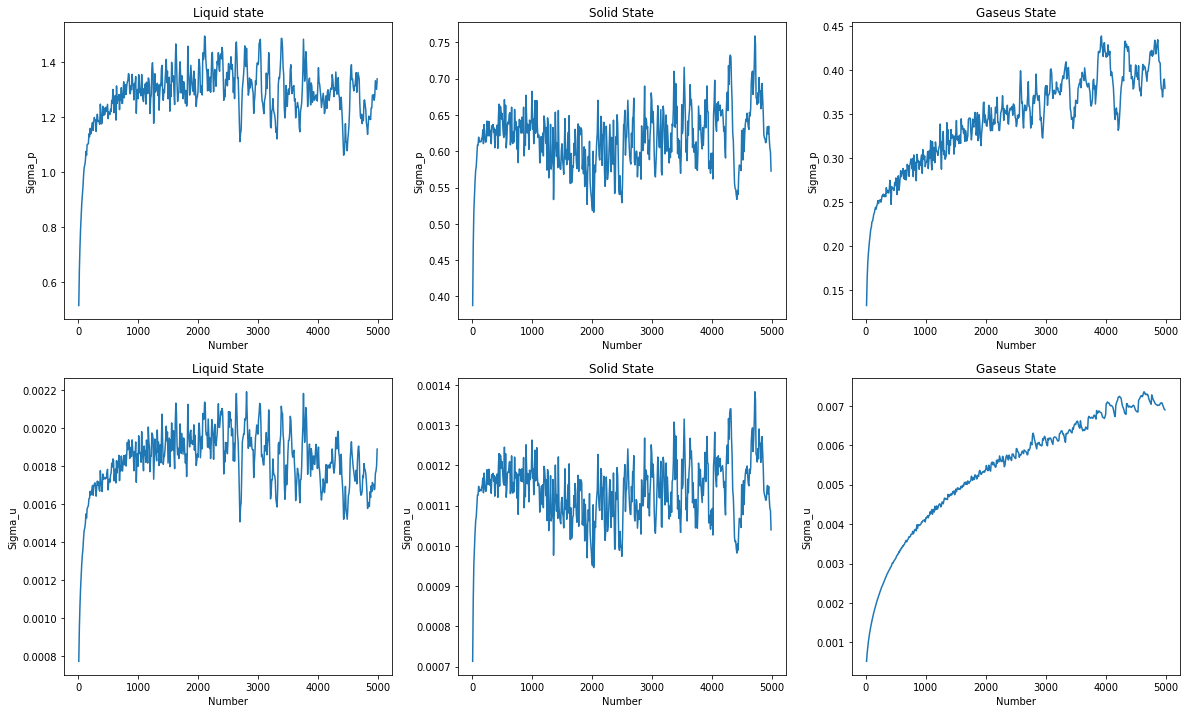

In [39]:
fig, axs = plt.subplots(2, 3, figsize = (20, 12))

axs[0, 0].plot(number, sigmap_liquid)    #gas 
axs[0, 0].set_title('Liquid state')
axs[0, 0].set(xlabel='Number', ylabel='Sigma_p')

axs[0, 1].plot(number, sigmap_solid)    #solid
axs[0, 1].set_title('Solid State')
axs[0, 1].set(xlabel='Number', ylabel='Sigma_p')

axs[0, 2].plot(number, sigmap_gas)    #gas
axs[0, 2].set_title('Gaseus State')
axs[0, 2].set(xlabel='Number', ylabel='Sigma_p')

axs[1, 0].plot(number, sigmau_liquid)    #liquid
axs[1, 0].set_title('Liquid State')
axs[1, 0].set(xlabel='Number', ylabel='Sigma_u')

axs[1, 1].plot(number, sigmau_solid)    #solid
axs[1, 1].set_title('Solid State')
axs[1, 1].set(xlabel='Number', ylabel='Sigma_u')

axs[1, 2].plot(number, sigmau_gas)    #gas
axs[1, 2].set_title('Gaseus State')
axs[1, 2].set(xlabel='Number', ylabel='Sigma_u')

# 7.4

In questo esercizio mostriamo i risultati della simulazione. In particolare mostriamo i grafici dei valori medi e delle incertezze dell'energia poteziale media per particelle (U/N) e della pressione (P) del sistema. In oltre compariamo i grafici della funzione g(r) ottenuti con la simulazione del sistema nell'ensemble NVT e NVE.

Sono stati simulati 10000 passi divisi in 100 blocchi. Prima di iniziare la simulazione abbiamo introdotto una fase di equilibrazione in cui le particelle sono state spostate 400 volte.

I parametri utilizzati per le simulazioni sono:
facciamo le simulazioni con i seguenti parmetri: 100 blocchi, 1000 passi a blocco, settiamo il delta in modo che acceptain rate sia di 50% circa. Questo algoritmo usa solo il metropolis. per quanto rigurada g(r) facciamo un istogramma: 100 bins: bin_size = (box/2.0)/(double)nbins. Istogramma è normalizzato di un fattore rho*N*deltaV-> quando faccio il grafico devo trasformare quella rho* in rho vera, la relazione è rho*=rho_vera*(sigma^3). Il grafico che sivuole fare considera solo la stima finale dell'istogramma dopo 100 blocchi gave.liquid/gave.solid/gave.gas

partiamo con liquid ->accettazione corretta delta= 0.2
solid-> va bene accettazione delta= 0.12
gas -> delta=10 accetazione del 60/61%

gas:
1. T*=1.2
2. numero particelle= 108
3. $\rho$*= 0.05
4. cut off radius= 5.0
5. delta= 0.12
6. numero di blocchi 100
7. numero di passi in ogni blocco 1000

liquid:
1. T*= 1.1
2. numero di particelle= 108
3. $\rho$*=0.8
4. cut off radius= 2.5
5. delta= 0.2
6. numero di blocchi= 100
7. numero di passi in ogni blocco= 1000

solid
1. T*= 0.8
2. numero di particelle= 108
3. $\rho$*=1.1
4. cut off radius= 2.2
5. delta= 0.12
6. numero di blocchi= 100
7. numero di simulazioni in ogni blocco= 1000

In [2]:
epot_solid_db = pd.read_csv(path + '/epot.solid', header = None, sep=",")
ave_solid_db = pd.read_csv(path + '/gave.solid', header = None, sep=",")
pres_solid_db = pd.read_csv(path + '/pres.solid', header = None, sep=",")
gofr_solid_db = pd.read_csv(path + '/gofr.solid', header = None, sep=",")


gofr_liquid_db = pd.read_csv(path + '/gofr.liquid', header = None, sep=",")
epot_liquid_db = pd.read_csv(path + '/epot.liquid', header = None, sep=",")
ave_liquid_db = pd.read_csv(path + '/gave.liquid', header = None, sep=",")
pres_liquid_db = pd.read_csv(path + '/pres.liquid', header = None, sep=",")


gofr_gas_db = pd.read_csv(path + '/gofr.gas', header = None, sep=",")
epot_gas_db = pd.read_csv(path + '/epot.gas', header = None, sep=",")
ave_gas_db = pd.read_csv(path + '/gave.gas', header = None, sep=",")
pres_gas_db = pd.read_csv(path + '/pres.gas', header = None, sep=",")





In [14]:
#ARGON
sigma_argon=0.34*10**(-9)
epsilon_argon=120*1.38*10**(-23)

#KRYPTON
sigma_krypton=0.364*10**(-9)
epsilon_krypton=164*1.38*10**(-23)

In [25]:
u_solid_Ar=np.array(list(epot_solid_db.iloc[:,2]))*epsilon_argon
erru_solid_Ar=np.array(list(epot_solid_db.iloc[:,3]))*epsilon_argon

u_liquid_Ar=np.array(list(epot_liquid_db.iloc[:,2]))*epsilon_argon
erru_liquid_Ar=np.array(list(epot_liquid_db.iloc[:,3]))*epsilon_argon

u_gas_Ar=np.array(list(epot_gas_db.iloc[:,2]))*epsilon_argon
erru_gas_Ar=np.array(list(epot_gas_db.iloc[:,3]))*epsilon_argon


p_solid_Ar=np.array(list(pres_solid_db.iloc[:,2]))*epsilon_argon/(sigma_argon**3)
errp_solid_Ar=np.array(list(pres_solid_db.iloc[:,3]))*epsilon_argon/(sigma_argon**3)

p_liquid_Ar=np.array(list(pres_liquid_db.iloc[:,2]))*epsilon_argon/(sigma_argon**3)
errp_liquid_Ar=np.array(list(pres_liquid_db.iloc[:,3]))*epsilon_argon/(sigma_argon**3)

p_gas_Ar=np.array(list(pres_gas_db.iloc[:,2]))*epsilon_argon/(sigma_argon**3)
errp_gas_Ar=np.array(list(pres_gas_db.iloc[:,3]))*epsilon_argon/(sigma_argon**3)

In [26]:
blocks=[]
for i in range(1,101):
    blocks.append(i)

Argon


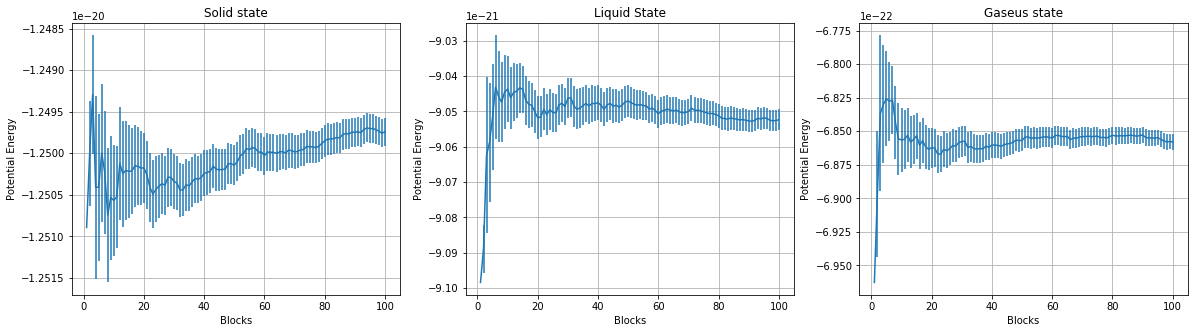

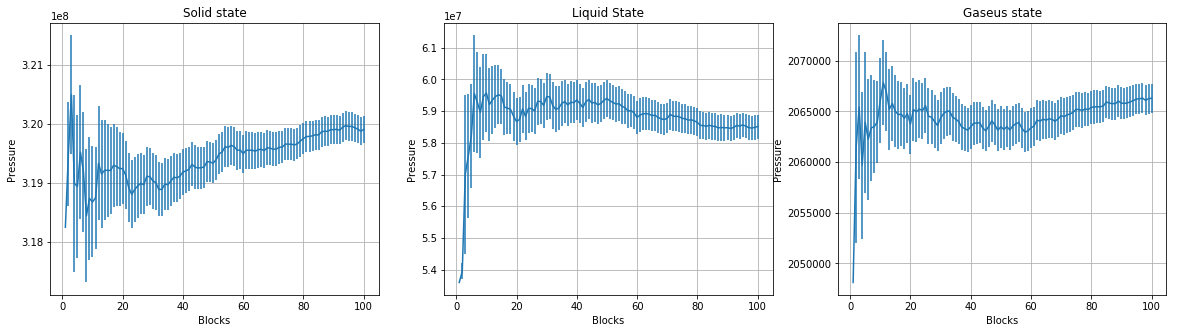

In [27]:
print('Argon')
plt.figure(1,figsize=(20, 5))
plt.subplot(1,3,1)
plt.errorbar(blocks, u_solid_Ar, yerr=erru_solid_Ar)    #solid 
plt.title("Solid state")
plt.xlabel('Blocks')
plt.ylabel('Potential Energy')
plt.grid(True)

plt.subplot(1,3,2)
plt.errorbar(blocks, u_liquid_Ar, yerr=erru_liquid_Ar)    #liquid
plt.title("Liquid State")
plt.xlabel('Blocks')
plt.ylabel('Potential Energy')
plt.grid(True)

plt.subplot(1,3,3)
plt.errorbar(blocks, u_gas_Ar, yerr=erru_gas_Ar)    #gas 
plt.title("Gaseus state")
plt.xlabel('Blocks')
plt.ylabel('Potential Energy')
plt.grid(True)

plt.show()

plt.figure(2,figsize=(20, 5))
plt.subplot(1,3,1)
plt.errorbar(blocks, p_solid_Ar, yerr=errp_solid_Ar)    #solid 
plt.title("Solid state")
plt.xlabel('Blocks')
plt.ylabel('Pressure')
plt.grid(True)

plt.subplot(1,3,2)
plt.errorbar(blocks, p_liquid_Ar, yerr=errp_liquid_Ar)    #liquid
plt.title("Liquid State")
plt.xlabel('Blocks')
plt.ylabel('Pressure')
plt.grid(True)

plt.subplot(1,3,3)
plt.errorbar(blocks, p_gas_Ar, yerr=errp_gas_Ar)    #gas 
plt.title('Gaseus state')
plt.xlabel('Blocks')
plt.ylabel('Pressure')
plt.grid(True)
plt.show()

In [28]:
u_solid_Kr=np.array(list(epot_solid_db.iloc[:,2]))*epsilon_krypton
erru_solid_Kr=np.array(list(epot_solid_db.iloc[:,3]))*epsilon_krypton

u_liquid_Kr=np.array(list(epot_liquid_db.iloc[:,2]))*epsilon_krypton
erru_liquid_Kr=np.array(list(epot_liquid_db.iloc[:,3]))*epsilon_krypton

u_gas_Kr=np.array(list(epot_gas_db.iloc[:,2]))*epsilon_krypton
erru_gas_Kr=np.array(list(epot_gas_db.iloc[:,3]))*epsilon_krypton


p_solid_Kr=np.array(list(pres_solid_db.iloc[:,2]))*epsilon_krypton/(sigma_krypton**3)
errp_solid_Kr=np.array(list(pres_solid_db.iloc[:,3]))*epsilon_krypton/(sigma_krypton**3)

p_liquid_Kr=np.array(list(pres_liquid_db.iloc[:,2]))*epsilon_krypton/(sigma_krypton**3)
errp_liquid_Kr=np.array(list(pres_liquid_db.iloc[:,3]))*epsilon_krypton/(sigma_krypton**3)

p_gas_Kr=np.array(list(pres_gas_db.iloc[:,2]))*epsilon_krypton/(sigma_krypton**3)
errp_gas_Kr=np.array(list(pres_gas_db.iloc[:,3]))*epsilon_krypton/(sigma_krypton**3)

Krypton


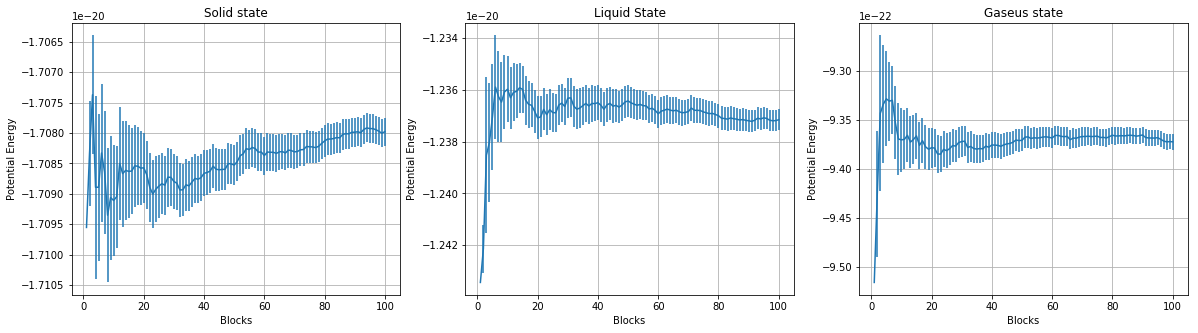

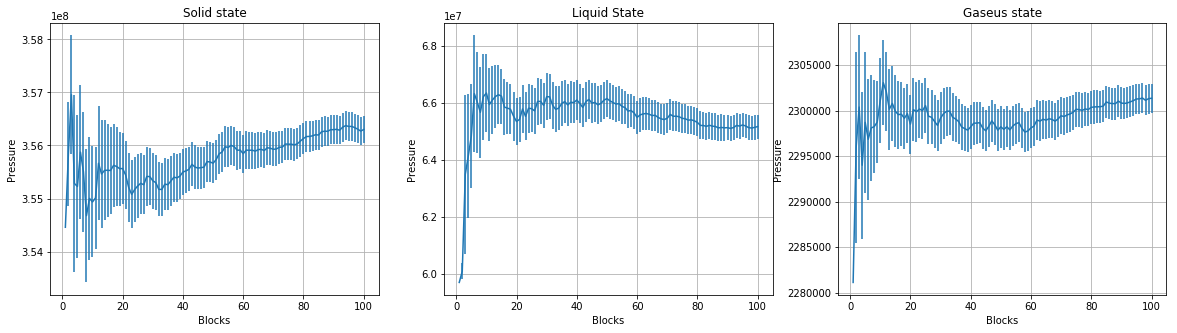

In [29]:
print('Krypton')
plt.figure(1,figsize=(20, 5))
plt.subplot(1,3,1)
plt.errorbar(blocks, u_solid_Kr, yerr=erru_solid_Kr)    #solid 
plt.title("Solid state")
plt.xlabel('Blocks')
plt.ylabel('Potential Energy')
plt.grid(True)

plt.subplot(1,3,2)
plt.errorbar(blocks, u_liquid_Kr, yerr=erru_liquid_Kr)    #liquid
plt.title("Liquid State")
plt.xlabel('Blocks')
plt.ylabel('Potential Energy')
plt.grid(True)

plt.subplot(1,3,3)
plt.errorbar(blocks, u_gas_Kr, yerr=erru_gas_Kr)    #gas 
plt.title("Gaseus state")
plt.xlabel('Blocks')
plt.ylabel('Potential Energy')
plt.grid(True)

plt.show()

plt.figure(2,figsize=(20, 5))
plt.subplot(1,3,1)
plt.errorbar(blocks, p_solid_Kr, yerr=errp_solid_Kr)    #solid 
plt.title("Solid state")
plt.xlabel('Blocks')
plt.ylabel('Pressure')
plt.grid(True)

plt.subplot(1,3,2)
plt.errorbar(blocks, p_liquid_Kr, yerr=errp_liquid_Kr)    #liquid
plt.title("Liquid State")
plt.xlabel('Blocks')
plt.ylabel('Pressure')
plt.grid(True)

plt.subplot(1,3,3)
plt.errorbar(blocks, p_gas_Kr, yerr=errp_gas_Kr)    #gas 
plt.title('Gaseus state')
plt.xlabel('Blocks')
plt.ylabel('Pressure')
plt.grid(True)
plt.show()

In [53]:
gr_liquid=np.array(list(ave_liquid_db.iloc[:,2]))
r_liquid = np.array(list(ave_liquid_db.iloc[:,1]))
err_liquid=np.array(list(ave_liquid_db.iloc[:,3]))

gr_solid=np.array(list(ave_solid_db.iloc[:,2]))
r_solid = np.array(list(ave_solid_db.iloc[:,1]))
err_solid=np.array(list(ave_solid_db.iloc[:,3]))

gr_gas=np.array(list(ave_gas_db.iloc[:,2]))
r_gas = np.array(list(ave_gas_db.iloc[:,1]))
err_gas=np.array(list(ave_gas_db.iloc[:,3]))

r_liquid_Ar = r_liquid*sigma_argon
r_liquid_Kr = r_liquid*sigma_krypton
r_solid_Ar = r_solid*sigma_argon
r_solid_Kr = r_solid*sigma_krypton
r_gas_Ar = r_gas*sigma_argon
r_gas_Kr = r_gas*sigma_krypton


ave_solid_NVE = pd.read_csv(path + '/g_ave_solid_NVE', header = None, sep=",")
ave_liquid_NVE = pd.read_csv(path + '/g_ave_liquid_NVE', header = None, sep=",")
ave_gas_NVE = pd.read_csv(path + '/g_ave_gas_NVE', header = None, sep=",")


gr_solid_NVE=np.array(list(ave_solid_NVE.iloc[:,1]))
r_solid_NVE = np.array(list(ave_solid_NVE.iloc[:,0]))
err_solid_NVE=np.array(list(ave_solid_NVE.iloc[:,2]))

r_solid_Ar_NVE = r_solid_NVE*sigma_argon
r_solid_Kr_NVE = r_solid_NVE*sigma_krypton

gr_liquid_NVE=np.array(list(ave_liquid_NVE.iloc[:,1]))
r_liquid_NVE = np.array(list(ave_liquid_NVE.iloc[:,0]))
err_liquid_NVE=np.array(list(ave_liquid_NVE.iloc[:,2]))

r_liquid_Ar_NVE = r_liquid_NVE*sigma_argon
r_liquid_Kr_NVE = r_liquid_NVE*sigma_krypton

gr_gas_NVE=np.array(list(ave_gas_NVE.iloc[:,1]))
r_gas_NVE = np.array(list(ave_gas_NVE.iloc[:,0]))
err_gas_NVE=np.array(list(ave_gas_NVE.iloc[:,2]))

r_gas_Ar_NVE = r_gas_NVE*sigma_argon
r_gas_Kr_NVE = r_gas_NVE*sigma_krypton


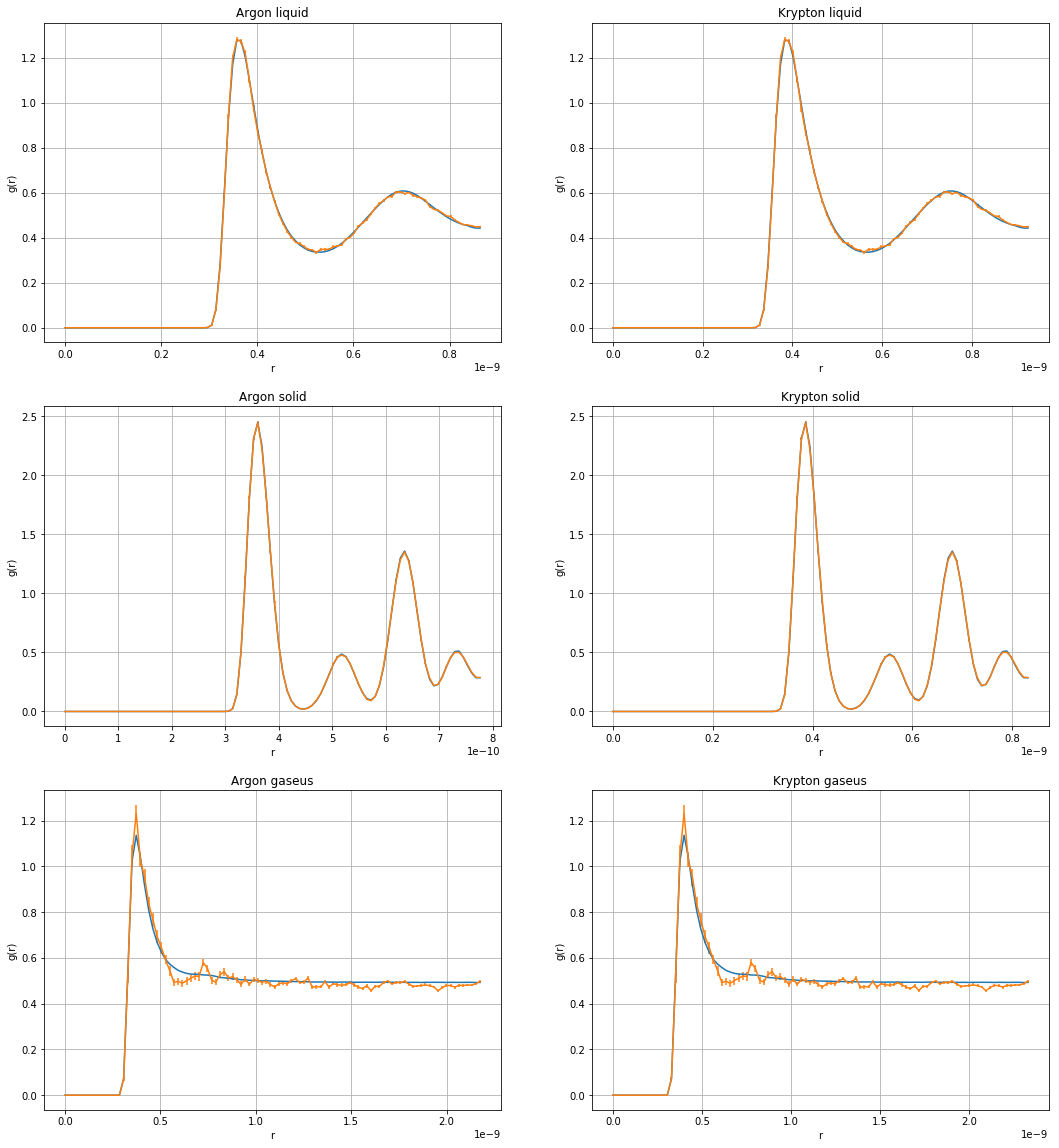

In [59]:
plt.figure(1,figsize=(18, 20))
plt.subplot(3, 2, 1)
plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('Argon liquid')
plt.errorbar(r_liquid_Ar, gr_liquid, yerr=err_liquid)
plt.errorbar(r_liquid_Ar_NVE, gr_liquid_NVE, yerr=err_liquid_NVE)
plt.grid(True)

plt.subplot(3, 2, 2)
plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('Krypton liquid')
plt.errorbar(r_liquid_Kr, gr_liquid, yerr=err_liquid)
plt.errorbar(r_liquid_Kr_NVE, gr_liquid_NVE, yerr=err_liquid_NVE)
plt.grid(True)

plt.subplot(3, 2, 3)
plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('Argon solid')
plt.errorbar(r_solid_Ar, gr_solid, yerr=err_solid)
plt.errorbar(r_solid_Ar_NVE, gr_solid_NVE, yerr=err_solid_NVE)
plt.grid(True)

plt.subplot(3, 2, 4)
plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('Krypton solid')
plt.errorbar(r_solid_Kr, gr_solid, yerr=err_solid)
plt.errorbar(r_solid_Kr_NVE, gr_solid_NVE, yerr=err_solid_NVE)
plt.grid(True)

plt.subplot(3, 2, 5)
plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('Argon gaseus')
plt.errorbar(r_gas_Ar, gr_gas, yerr=err_gas)
plt.errorbar(r_gas_Ar_NVE, gr_gas_NVE, yerr=err_gas_NVE)
plt.grid(True)

plt.subplot(3, 2, 6)
plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('Krypton gaseus')
plt.errorbar(r_gas_Kr, gr_gas, yerr=err_gas)
plt.errorbar(r_gas_Kr_NVE, gr_gas_NVE, yerr=err_gas_NVE)
plt.grid(True)


I risultati sono compatibili con quelli ottenuti mediante la simulazione di dinamica molecolare.